In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import statistics
import random
from geneticalgorithm import geneticalgorithm as ga
#from google.colab import files
from scipy.ndimage import binary_dilation
from sklearn.cluster import DBSCAN


## Functions

In [ ]:

def load_map(filename='sample_grid.csv'):
    df = pd.read_csv(filename)

    # Mapping of types to numerical values
    type_to_num = {'building': 0, 'road': 1, 'green_space': 2, 'water': 3}
    num_to_type = {v: k for k, v in type_to_num.items()}
    df['type_num'] = df['type'].map(type_to_num)

    # Creating pivot tables for types and temperatures
    type_pivot = df.pivot(index='y', columns='x', values='type_num')
    temp_pivot = df.pivot(index='y', columns='x', values='temp_fac')

    # Sort rows and columns by alignment
    type_pivot = type_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)
    temp_pivot = temp_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

    # Conversion to NumPy array for quick access
    type_matrix = type_pivot.values
    temp_matrix = temp_pivot.values

    return type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type

# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

In [ ]:

def plot_terrain_map(type_pivot):
    """
    Plots the terrain type map.
    
    Parameters:
    - type_pivot: 2D numpy array of terrain types
    """
    cmap_types = mcolors.ListedColormap(['black', 'tab:gray', 'tab:green', 'tab:blue'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap_types.N)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(type_pivot, origin='lower', cmap=cmap_types, norm=norm)
    ax.set_title("Terrain Type Map")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Legend
    patches = [
        mpatches.Patch(color='black', label='Building'),
        mpatches.Patch(color='tab:gray', label='Road'),
        mpatches.Patch(color='tab:green', label='Green Space'),
        mpatches.Patch(color='tab:blue', label='Water')
    ]
    ax.legend(handles=patches, loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_heatmap(temp_matrix, vmin=None, vmax=None):
    """
    Plots the temperature heatmap.

    Parameters:
    - temp_matrix: 2D numpy array of temperatures
    - vmin, vmax: Optional color scale limits
    """
    mean_temp = np.mean(temp_matrix)
    max_temp = np.max(temp_matrix)

    if vmin is None:
        vmin = np.min(temp_matrix)
    if vmax is None:
        vmax = np.max(temp_matrix)

    plt.figure(figsize=(8, 6))
    plt.imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    plt.title("Heatmap - Temperature Condition")
    cbar = plt.colorbar()
    cbar.set_label("Temperature")

    plt.text(0.02, 0.98, f"Mean: {mean_temp:.2f}\nMax: {max_temp:.2f}",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.tight_layout()
    plt.show()


In [ ]:

def detect_heat_islands(temp_matrix, threshold=32):
    """
    Detects heat islands and their edges in a temperature matrix.

    Returns:
        cluster_grid: 2D grid with cluster labels (-1 = no cluster)
        edges: 2D boolean grid where True indicates edge of cluster
    """
    # Get grid dimensions
    H, W = temp_matrix.shape

    # Get all coordinates
    y_coords, x_coords = np.indices((H, W))
    coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))
    temps = temp_matrix.ravel()

    # Select hot regions
    hot_mask = temps >= threshold
    hot_coords = coords[hot_mask]

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=1.5, min_samples=3)
    hot_clusters = dbscan.fit_predict(hot_coords)

    # Create cluster grid
    cluster_grid = np.full((H, W), fill_value=-1)
    for (y, x), cluster_label in zip(hot_coords, hot_clusters):
        cluster_grid[y, x] = cluster_label

    # Identify cluster edges
    edges = np.zeros_like(cluster_grid, dtype=bool)
    for cluster_label in np.unique(hot_clusters[hot_clusters >= 0]):
        cluster_mask = cluster_grid == cluster_label
        dilated_mask = binary_dilation(cluster_mask, structure=np.ones((3, 3)))
        edge = dilated_mask & cluster_mask
        edges |= edge

    return cluster_grid, edges


 

In [ ]:
def compute_cooled_map(temp_matrix, best_solution, tree_species, num_candidates):
    """
    Compute cooled temperature map from GA solution.
    
    Parameters:
    - temp_matrix: original temperature map (2D array)
    - best_solution: solution vector from GA
    - tree_species: dictionary of tree properties
    - num_candidates: number of candidates in best_solution
    
    Returns:
    - cooled_map: 2D numpy array with cooling effect applied
    """
    H, W = temp_matrix.shape
    Y, X = np.indices((H, W))

    cooled_map = np.copy(temp_matrix)

    for i in range(num_candidates):
        row = int(round(best_solution[4 * i]))
        col = int(round(best_solution[4 * i + 1]))
        active = 1 if int(round(best_solution[4 * i + 2])) >= 1 else 0
        t = int(round(best_solution[4 * i + 3]))
        t = max(0, min(3, t))
        if not active:
            continue

        tree_key = f"tree_{t + 1}"
        props = tree_species[tree_key]
        sigma = 1 + (1 - props["decay"]) * 5
        dist2 = (Y - row)**2 + (X - col)**2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
        cooled_map -= effect

    # Clip temperature to realistic range
    cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())
    return cooled_map

cooled_map = compute_cooled_map(temp_matrix, best_sol, tree_species, num_candidates)

In [ ]:
def compare_heatmaps(temp_matrix, best_solution, tree_species, num_candidates):
    """
    Plot side-by-side comparison of original and cooled heatmaps with trees.

    Parameters:
    - temp_matrix: original temperature map (2D array)
    - best_solution: solution vector from GA
    - tree_species: dict of tree properties
    - num_candidates: number of candidates in best_solution
    """
    H, W = temp_matrix.shape
    Y, X = np.indices((H, W))

    # --- Decode solution ---
    active_trees = []
    for i in range(num_candidates):
        row = int(round(best_solution[4 * i]))
        col = int(round(best_solution[4 * i + 1]))
        active = 1 if int(round(best_solution[4 * i + 2])) >= 1 else 0
        t = int(round(best_solution[4 * i + 3]))
        t = max(0, min(3, t))
        if active:
            active_trees.append((row, col, t))

    # --- Apply cooling ---
    cooled_map = np.copy(temp_matrix)
    for row_center, col_center, t in active_trees:
        tree_key = f"tree_{t + 1}"
        props = tree_species[tree_key]
        sigma = 1 + (1 - props["decay"]) * 5
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
        cooled_map -= effect

    cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    vmin = np.min(temp_matrix)
    vmax = np.max(temp_matrix)

    # Left: Original heatmap
    im0 = axes[0].imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title("Original Heatmap")
    plt.colorbar(im0, ax=axes[0], shrink=0.85, label='Temperature (°C)')

    # Right: Cooled heatmap
    im1 = axes[1].imshow(cooled_map, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title("Cooled Heatmap with Tree Placement")

    # Add tree markers
    species_colors = {
        "tree_1": "green",
        "tree_2": "orange",
        "tree_3": "purple",
        "tree_4": "cyan"
    }
    for row, col, t in active_trees:
        tree_key = f"tree_{t + 1}"
        axes[1].scatter(col, row, marker='^', s=60,
                        color=species_colors[tree_key], edgecolor='black')

    # Legend
    legend_patches = [
        mpatches.Patch(color=color, label=key)
        for key, color in species_colors.items()
    ]
    axes[1].legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_temperature_histogram(original_map, cooled_map, bins=30):
    """
    Plot histogram comparing temperature distributions before and after cooling.

    Parameters:
    - original_map: 2D array (before cooling)
    - cooled_map: 2D array (after cooling)
    - bins: number of bins for the histogram
    """
    orig_flat = original_map.flatten()
    cool_flat = cooled_map.flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(orig_flat, bins=bins, alpha=0.6, label='Original', color='red', edgecolor='black')
    plt.hist(cool_flat, bins=bins, alpha=0.6, label='Cooled', color='blue', edgecolor='black')

    plt.axvline(np.mean(orig_flat), color='red', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(cool_flat), color='blue', linestyle='dashed', linewidth=1.5)

    plt.title('Temperature Distribution Before and After Cooling')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def summarize_solution(temp_matrix, best_solution, tree_species, num_candidates, budget_max):
    """
    Compute summary statistics for a GA solution.
    
    Parameters:
    - temp_matrix: original temperature map
    - best_solution: solution vector from GA
    - tree_species: dictionary of tree properties
    - num_candidates: number of candidates in best_solution
    - budget_max: max allowed budget
    """
    H, W = temp_matrix.shape
    Y, X = np.indices((H, W))

    cooled_map = np.copy(temp_matrix)
    species_count = {"tree_1": 0, "tree_2": 0, "tree_3": 0, "tree_4": 0}
    total_cost = 0

    for i in range(num_candidates):
        row = int(round(best_solution[4 * i]))
        col = int(round(best_solution[4 * i + 1]))
        active = 1 if int(round(best_solution[4 * i + 2])) >= 1 else 0
        t = int(round(best_solution[4 * i + 3]))
        t = max(0, min(3, t))
        if not active:
            continue

        tree_key = f"tree_{t + 1}"
        species_count[tree_key] += 1
        total_cost += tree_species[tree_key]["base_price"]

        props = tree_species[tree_key]
        sigma = 1 + (1 - props["decay"]) * 5
        dist2 = (Y - row)**2 + (X - col)**2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
        cooled_map -= effect

    cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())

    # Compute temperature statistics
    orig_flat = temp_matrix.flatten()
    cool_flat = cooled_map.flatten()

    print("\n===== Summary Statistics =====")
    print(f"Total Trees Planted: {sum(species_count.values())}")
    for key, count in species_count.items():
        print(f"  {key}: {count} trees")
    print(f"\nTotal Budget Used: {total_cost} / {budget_max}")
    print(f"\nTemperature Before → Mean: {np.mean(orig_flat):.2f}°C | Max: {np.max(orig_flat):.2f}°C")
    print(f"Temperature After  → Mean: {np.mean(cool_flat):.2f}°C | Max: {np.max(cool_flat):.2f}°C")

In [ ]:

plot_terrain_map(type_pivot)
plot_heatmap(temp_matrix)

In [ ]:
cluster_grid, edges = detect_heat_islands(temp_matrix, threshold=32)

plt.figure(figsize=(8, 6))
plt.imshow(temp_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Temperature (°C)")
plt.contour(edges, colors='yellow', linewidths=1.5)
plt.title("Heat Map with Hot Region Cluster Edges")
plt.axis('off')
plt.show()


## Global Parameters

In [ ]:
num_candidates = 50
tree_species = {
    "tree_1": {"base_price": 50, "cooling": 1.0, "decay": 0.35},
    "tree_2": {"base_price": 70, "cooling": 1.2, "decay": 0.40},
    "tree_3": {"base_price": 90, "cooling": 1.5, "decay": 0.30},
    "tree_4": {"base_price": 110, "cooling": 1.8, "decay": 0.22},
}

budget_max = 5000


w_mean = 0.25   # Weight for average temperature
w_max  = 0.75   # Weight for maximum temperature (hot spot)

## Objective function

In [115]:
def objective_function(X):
    penalty = 0
    total_cost = 0
    active_elements = []

    for i in range(num_candidates):
        row = int(round(X[4 * i]))
        col = int(round(X[4 * i + 1]))
        active = 1 if int(round(X[4 * i + 2])) >= 1 else 0
        t = int(round(X[4 * i + 3]))
        t = max(0, min(3, t))

        if active:
            if row < 0 or row >= H or col < 0 or col >= W:
                penalty += 1e6
                continue
            if type_matrix[row, col] == type_to_num['building']:
                penalty += 1e6
                continue
            tree_key = f"tree_{t + 1}"
            props = tree_species[tree_key]
            total_cost += props["base_price"]
            active_elements.append((row, col, tree_key))

    if total_cost > budget_max:
        penalty += 1e6 * (total_cost - budget_max)

    cooled_map = np.copy(temp_matrix)
    Y, X_grid = np.indices((H, W))
    for row_c, col_c, tree_key in active_elements:
        props = tree_species[tree_key]
        sigma = 1 + (1 - props["decay"]) * 5
        dist2 = (Y - row_c)**2 + (X_grid - col_c)**2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
        cooled_map -= effect

    cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())

    avg_temp = np.mean(cooled_map)
    max_temp = np.max(cooled_map)
    n_trees = len(active_elements)

    # Reward for using more budget / planting more trees
    reward = -0.001 * total_cost - 0.01 * n_trees

    return w_mean * avg_temp + w_max * max_temp + penalty + reward


## Initial situation

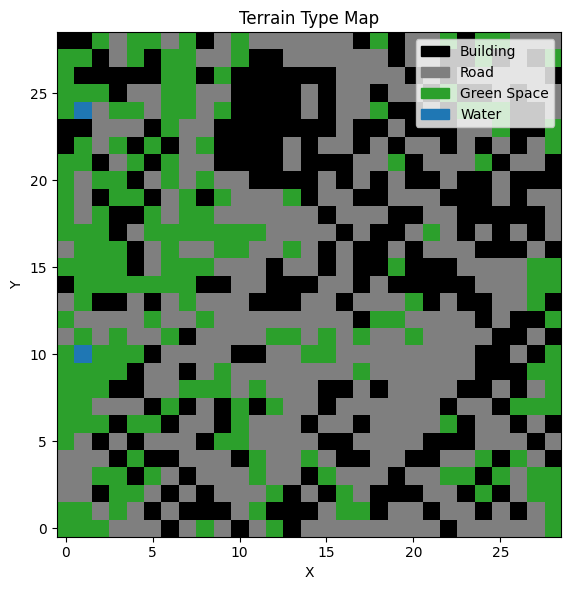

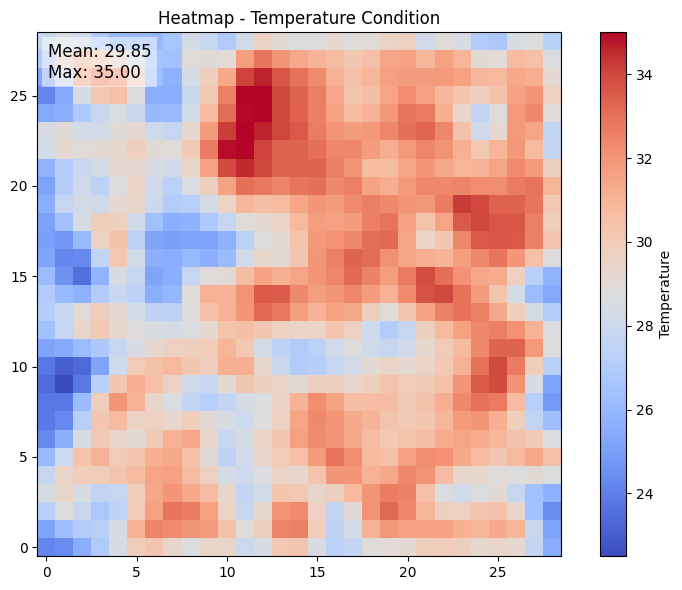

In [120]:

plot_terrain_map(type_pivot)
plot_heatmap(temp_matrix)

## Genetic Algorithm

In [116]:

# Each candidate has 4 variables: row, col, active, type
var_bound = []
for _ in range(num_candidates):
    var_bound.append([0, H-1])  # row
    var_bound.append([0, W-1])  # col
    var_bound.append([0, 1])    # active
    var_bound.append([0, 2])    # type
var_bound = np.array(var_bound)

In [117]:

# GA Parameters
params = {
    'max_num_iteration': 1000,
    'population_size': 500,
    'mutation_probability': 0.2,
    'elit_ratio': 0.05,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 100
}

In [118]:
model = ga(function=objective,
           dimension=4 * num_candidates,
           variable_type='int',
           variable_boundaries=var_bound,
           algorithm_parameters=params)

 The best solution found:                                                                           
 [19. 13.  1.  0. 19. 16.  1.  2. 17. 14.  1.  0. 11.  6.  0.  0. 17. 12.
  1.  2. 21. 13.  1.  2. 18. 27.  0.  0. 12. 24.  0.  2. 16. 13.  0.  2.
 21. 21.  1.  2. 24. 19.  0.  2. 19.  0.  0.  2. 26. 24.  0.  0. 22.  8.
  0.  0. 17. 21.  1.  2. 17. 14.  1.  2. 26. 16.  0.  0. 13. 25.  0.  0.
 23. 24.  0.  1. 14.  1.  0.  2. 26. 17.  0.  0. 13. 19.  1.  2. 28. 24.
  0.  2.  0.  7.  0.  2. 14. 20.  0.  1. 20. 15.  1.  1. 21.  7.  0.  2.
  9. 20.  0.  0. 10. 21.  1.  1. 10.  3.  0.  2. 12.  5.  0.  1.  5. 24.
  0.  1.  0.  8.  0.  0.  6.  6.  0.  1.  8. 22.  0.  0. 15. 28.  0.  0.
 16. 27.  0.  0. 19. 23.  0.  0. 23. 19.  0.  0. 10. 12.  1.  0. 12.  4.
  0.  0.  0.  7.  0.  2.  7. 12.  1.  0. 18. 14.  0.  2. 26.  8.  0.  1.
 12. 15.  1.  2.  8. 12.  0.  2. 16. 21.  0.  2.  9.  8.  1.  0.  8. 15.
  0.  1.]

 Objective function:
 31.322016445880152


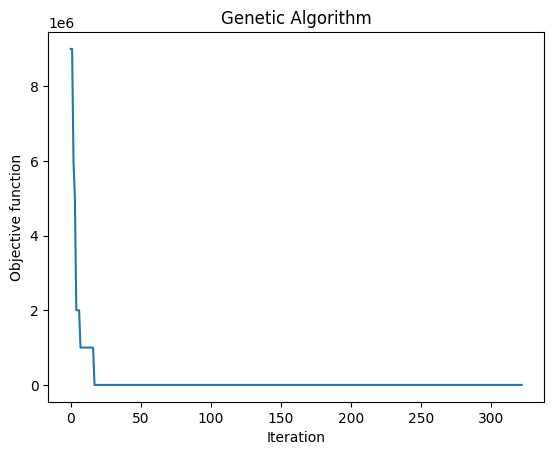


--- Single Run Result (50/50 Weighting) ---
Best solution found: [19. 13.  1.  0. 19. 16.  1.  2. 17. 14.  1.  0. 11.  6.  0.  0. 17. 12.
  1.  2. 21. 13.  1.  2. 18. 27.  0.  0. 12. 24.  0.  2. 16. 13.  0.  2.
 21. 21.  1.  2. 24. 19.  0.  2. 19.  0.  0.  2. 26. 24.  0.  0. 22.  8.
  0.  0. 17. 21.  1.  2. 17. 14.  1.  2. 26. 16.  0.  0. 13. 25.  0.  0.
 23. 24.  0.  1. 14.  1.  0.  2. 26. 17.  0.  0. 13. 19.  1.  2. 28. 24.
  0.  2.  0.  7.  0.  2. 14. 20.  0.  1. 20. 15.  1.  1. 21.  7.  0.  2.
  9. 20.  0.  0. 10. 21.  1.  1. 10.  3.  0.  2. 12.  5.  0.  1.  5. 24.
  0.  1.  0.  8.  0.  0.  6.  6.  0.  1.  8. 22.  0.  0. 15. 28.  0.  0.
 16. 27.  0.  0. 19. 23.  0.  0. 23. 19.  0.  0. 10. 12.  1.  0. 12.  4.
  0.  0.  0.  7.  0.  2.  7. 12.  1.  0. 18. 14.  0.  2. 26.  8.  0.  1.
 12. 15.  1.  2.  8. 12.  0.  2. 16. 21.  0.  2.  9.  8.  1.  0.  8. 15.
  0.  1.]


In [119]:
model.run()
best_sol = model.output_dict['variable']
print("\n--- Single Run Result (50/50 Weighting) ---")
print("Best solution found:", best_sol)

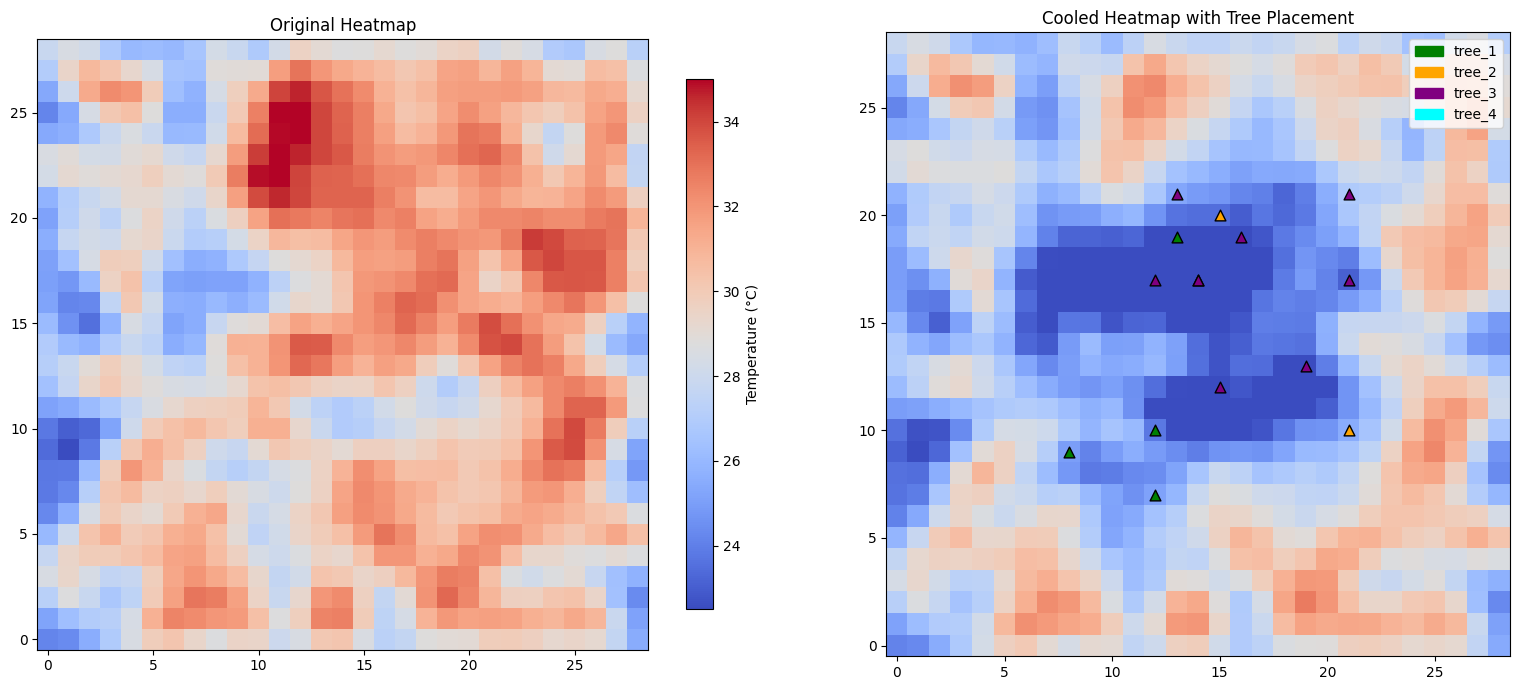

In [121]:
compare_heatmaps(temp_matrix, best_sol, tree_species, num_candidates)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def compare_heatmaps(temp_matrix, best_solution, tree_species, num_candidates):
    """
    Plot side-by-side comparison of original and cooled heatmaps with trees.

    Parameters:
    - temp_matrix: original temperature map (2D array)
    - best_solution: solution vector from GA
    - tree_species: dict of tree properties
    - num_candidates: number of candidates in best_solution
    """
    H, W = temp_matrix.shape
    Y, X = np.indices((H, W))

    # --- Decode solution ---
    active_trees = []
    for i in range(num_candidates):
        row = int(round(best_solution[4 * i]))
        col = int(round(best_solution[4 * i + 1]))
        active = 1 if int(round(best_solution[4 * i + 2])) >= 1 else 0
        t = int(round(best_solution[4 * i + 3]))
        t = max(0, min(3, t))
        if active:
            active_trees.append((row, col, t))

    # --- Apply cooling ---
    cooled_map = np.copy(temp_matrix)
    for row_center, col_center, t in active_trees:
        tree_key = f"tree_{t + 1}"
        props = tree_species[tree_key]
        sigma = 1 + (1 - props["decay"]) * 5
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
        cooled_map -= effect

    cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    vmin = np.min(temp_matrix)
    vmax = np.max(temp_matrix)

    # Left: Original heatmap
    im0 = axes[0].imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title("Original Heatmap")
    plt.colorbar(im0, ax=axes[0], shrink=0.85, label='Temperature (°C)')

    # Right: Cooled heatmap
    im1 = axes[1].imshow(cooled_map, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title("Cooled Heatmap with Tree Placement")

    # Add tree markers
    species_colors = {
        "tree_1": "green",
        "tree_2": "orange",
        "tree_3": "purple",
        "tree_4": "cyan"
    }
    for row, col, t in active_trees:
        tree_key = f"tree_{t + 1}"
        axes[1].scatter(col, row, marker='^', s=60,
                        color=species_colors[tree_key], edgecolor='black')

    # Legend
    legend_patches = [
        mpatches.Patch(color=color, label=key)
        for key, color in species_colors.items()
    ]
    axes[1].legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()
    plt.show()


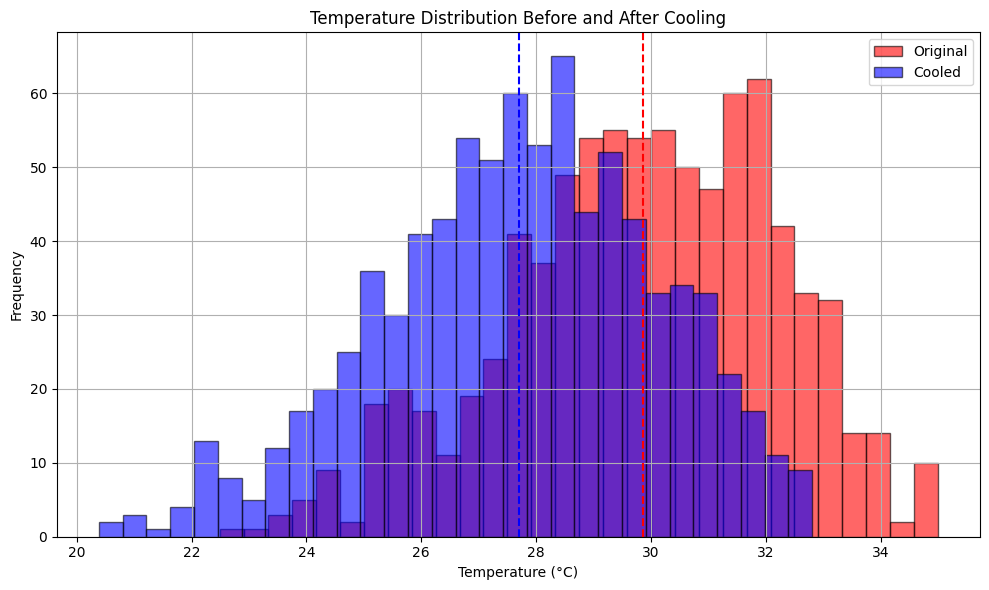

In [122]:
plot_temperature_histogram(temp_matrix, cooled_map)


In [123]:
summarize_solution(temp_matrix, best_sol, tree_species, num_candidates, budget_max)



===== Summary Statistics =====
Total Trees Planted: 15
  tree_1: 5 trees
  tree_2: 2 trees
  tree_3: 8 trees
  tree_4: 0 trees

Total Budget Used: 1110 / 5000

Temperature Before → Mean: 29.85°C | Max: 35.00°C
Temperature After  → Mean: 27.15°C | Max: 32.71°C


## ACO

In [128]:
def update_pheromone(best_solution, pheromone, evaporation_rate=0.05, reinforcement=0.3):
    """Update pheromone levels with evaporation and reinforcement."""
    pheromone *= (1 - evaporation_rate)
    for (row, col, species) in best_solution:
        pheromone[row, col] += reinforcement

def probabilistic_selection(type_matrix, pheromone, used_cells):
    """Select a (row, col) for placing a tree."""
    H, W = type_matrix.shape
    valid_positions = [
        (i, j) for i in range(H) for j in range(W)
        if type_matrix[i, j] != type_to_num['building'] and (i, j) not in used_cells
    ]
    if not valid_positions:
        return None

    probs = np.array([pheromone[i, j] for (i, j) in valid_positions])
    probs /= np.sum(probs)
    selected_idx = np.random.choice(len(valid_positions), p=probs)
    return valid_positions[selected_idx]

def ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                            iterations=200, num_ants=10,
                            evaporation_rate=0.05, reinforcement=0.3):
    """
    Ant Colony Optimization for tree placement.
    """

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    best_solution = []
    best_quality = float('-inf')

    min_tree_cost = min(tree_species[tk]["base_price"] for tk in tree_species)


    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()

            while budget_remaining >= min_tree_cost:
                pos = probabilistic_selection(type_matrix, pheromone, used_cells)
                if pos is None:
                    break
                row, col = pos

                # Randomly choose a tree species
                species_idx = np.random.randint(0, 4)
                species_key = f"tree_{species_idx + 1}"
                cost = tree_species[species_key]["base_price"]

                if budget_remaining >= cost:
                    solution.append((row, col, species_idx))
                    used_cells.add(pos)
                    budget_remaining -= cost
                else:
                    break

            cooled_map = np.copy(temp_matrix)
            Y, X = np.indices((H, W))
            for (row_center, col_center, t) in solution:
                tree_key = f"tree_{t + 1}"
                props = tree_species[tree_key]
                sigma = 1 + (1 - props["decay"]) * 5
                dist2 = (Y - row_center)**2 + (X - col_center)**2
                effect = props["cooling"] * np.exp(-dist2 / (2 * sigma**2))
                cooled_map -= effect

            cooled_map = np.clip(cooled_map, a_min=10, a_max=temp_matrix.max())
            avg_temp = np.mean(cooled_map)
            max_temp = np.max(cooled_map)
            total_cost = sum(tree_species[f"tree_{t + 1}"]["base_price"] for (_, _, t) in solution)

            if total_cost > budget_max:
                quality = -1e10  # Discard over-budget solutions
            else:
                objective_value = w_mean * avg_temp + w_max * max_temp
                quality = -objective_value
                if quality > best_quality:
                    best_solution = solution.copy()
                    best_quality = quality

            

        update_pheromone(best_solution, pheromone, evaporation_rate, reinforcement)

    return best_solution


In [129]:
aco_solution = ant_colony_optimization(type_matrix, temp_matrix, tree_species,
                                       iterations=200, num_ants=10,
                                       evaporation_rate=0.05, reinforcement=0.3)

print("\n--- ACO Solution ---")
print(f"Number of placements: {len(aco_solution)}")
for (row, col, t) in aco_solution:
    print(f"Position: ({row}, {col}) - Tree: tree_{t+1}")



--- ACO Solution ---
Number of placements: 58
Position: (3, 12) - Tree: tree_4
Position: (26, 25) - Tree: tree_4
Position: (10, 0) - Tree: tree_4
Position: (12, 25) - Tree: tree_4
Position: (3, 3) - Tree: tree_4
Position: (6, 11) - Tree: tree_3
Position: (4, 9) - Tree: tree_2
Position: (5, 3) - Tree: tree_4
Position: (0, 3) - Tree: tree_3
Position: (19, 13) - Tree: tree_4
Position: (24, 24) - Tree: tree_1
Position: (8, 21) - Tree: tree_3
Position: (25, 0) - Tree: tree_4
Position: (3, 27) - Tree: tree_2
Position: (16, 0) - Tree: tree_2
Position: (25, 27) - Tree: tree_4
Position: (8, 25) - Tree: tree_1
Position: (10, 22) - Tree: tree_4
Position: (14, 10) - Tree: tree_3
Position: (23, 8) - Tree: tree_4
Position: (14, 18) - Tree: tree_2
Position: (6, 25) - Tree: tree_2
Position: (14, 26) - Tree: tree_4
Position: (21, 22) - Tree: tree_2
Position: (19, 3) - Tree: tree_3
Position: (26, 9) - Tree: tree_1
Position: (17, 1) - Tree: tree_3
Position: (25, 22) - Tree: tree_3
Position: (12, 14) - T

In [130]:
def convert_aco_to_ga_format(aco_solution, num_candidates):
    """
    Convert ACO solution [(row, col, species), ...] to GA solution format.
    
    Parameters:
    - aco_solution: list of (row, col, species)
    - num_candidates: total number of candidates
    
    Returns:
    - ga_solution: 1D numpy array in GA format
    """
    ga_solution = []
    for (row, col, t) in aco_solution:
        ga_solution.extend([row, col, 1, t])  # active = 1
    # Fill the rest with inactive candidates
    missing = num_candidates - len(aco_solution)
    ga_solution.extend([0, 0, 0, 0] * missing)
    return np.array(ga_solution)


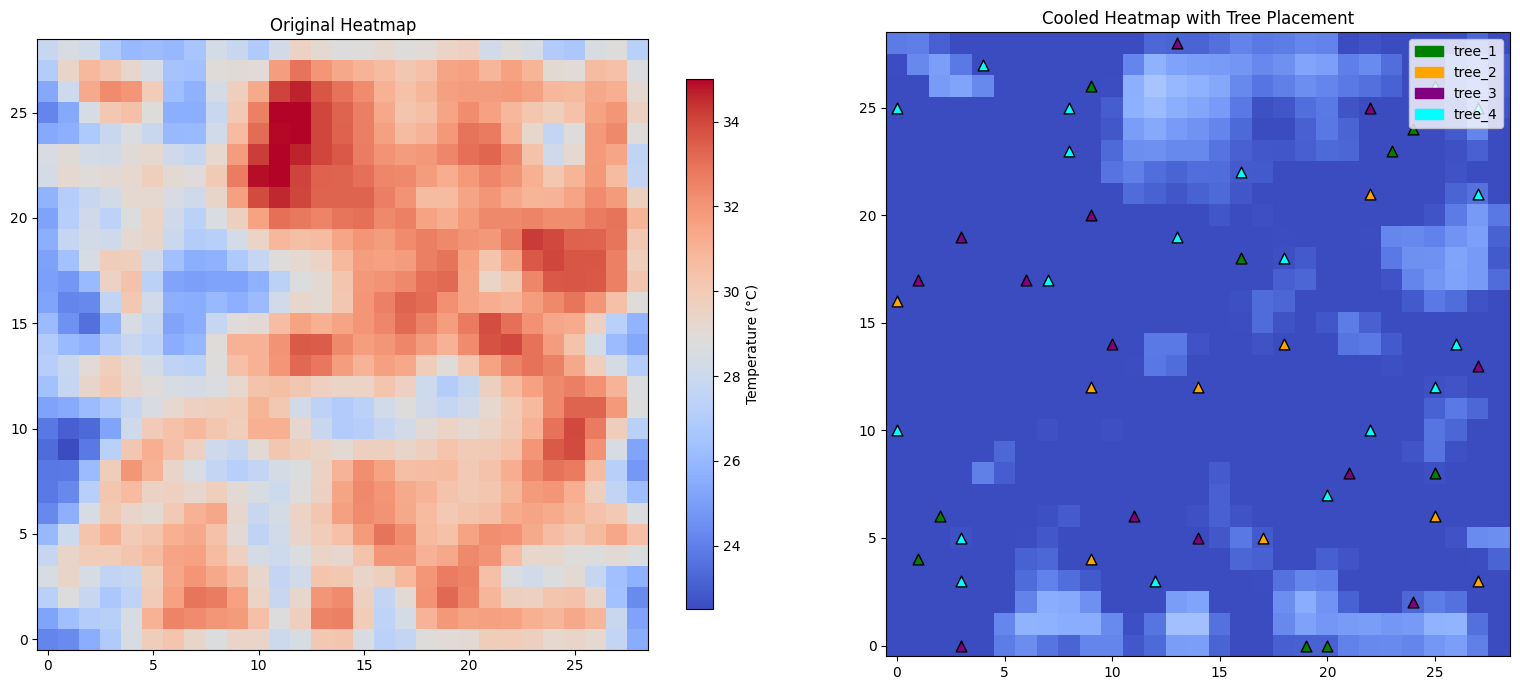


===== Summary Statistics =====
Total Trees Planted: 50
  tree_1: 9 trees
  tree_2: 9 trees
  tree_3: 13 trees
  tree_4: 19 trees

Total Budget Used: 4340 / 5000

Temperature Before → Mean: 29.85°C | Max: 35.00°C
Temperature After  → Mean: 21.27°C | Max: 26.56°C


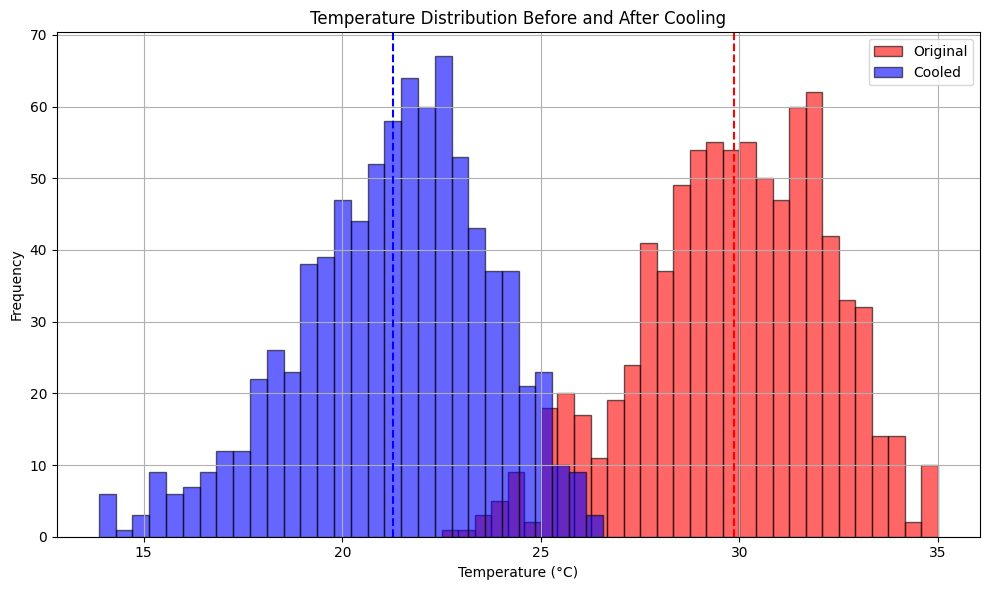

In [131]:

# Convert
aco_ga_solution = convert_aco_to_ga_format(aco_solution, num_candidates)

cooled_map_aco = compute_cooled_map(temp_matrix, aco_ga_solution, tree_species, num_candidates)
compare_heatmaps(temp_matrix, aco_ga_solution, tree_species, num_candidates)
summarize_solution(temp_matrix, aco_ga_solution, tree_species, num_candidates, budget_max)
plot_temperature_histogram(temp_matrix, cooled_map_aco)